<a href="https://colab.research.google.com/github/MaidenTaief/Music_Final/blob/main/Song_RecSys_Content_Collaborative.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Collaborative Filtering

###Loading and Preparing Data
First, we set the path to our dataset and load our aggregated data, which includes user IDs and playlist names. This is crucial because we need to know which users interacted with which playlists. We then convert user IDs and playlist names into categorical data types. This conversion helps in indexing and speeds up operations since categorical data uses integers internally, which are faster to process than strings.

To establish a direct mapping between user IDs and their indices in our matrices, as well as between playlist names and their indices, we create two dictionaries: `user_id_to_index` and `playlist_index_to_name`. These mappings are essential for efficiently looking up and referring to specific users and playlists in the subsequent steps.

###Interaction Matrix and Similarity Calculation
We load a pre-saved sparse matrix, `playlist_interaction_matrix`, that represents interactions between users and playlists. Using this matrix, we compute the cosine similarity among users. Cosine similarity helps us understand how similar two users are based on their interactions with various playlists. This similarity metric is a cornerstone of collaborative filtering, allowing us to predict a user's preferences based on the preferences of other similar users.

###Recommendation Function

The `recommend_playlists` function is designed to recommend playlist names to a user based on the preferences of similar users. Here's a breakdown of how this function works:

- **User Index Conversion:** Convert the provided user ID to its corresponding index using the `user_id_to_index` mapping.
- **Similarity Score Retrieval:** Fetch the cosine similarity scores for the given user against all other users.
- **Score Aggregation:** Iterate through each user, weighted by their similarity to the target user, to compile a score for each playlist based on how those similar users interacted with the playlists.
- **Result Compilation:** Zero out scores for playlists the user has already interacted with to ensure we only recommend new content. Then, sort the scores in descending order and pick the top N playlists.

By focusing on playlists favored by users with similar tastes and excluding already familiar content, we can make personalized recommendations that are likely to be of interest.

###Example Usage

To demonstrate the functionality of this system, we use an example user ID and call the `recommend_playlists` function. This example illustrates how you can input any user ID from the dataset and retrieve personalized playlist recommendations.

The output shows the top five recommended playlists for the user, providing a practical example of the recommendation system in action. These recommendations are tailored to the user's inferred preferences, showcasing the effectiveness of collaborative filtering.

In [29]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, load_npz
import pickle

def optimized_recommend_playlists(user_id, user_id_to_index, user_similarity_matrix, interaction_matrix, playlist_index_to_name, agg_data, top_n=5):
    """
    Optimized recommendation function to suggest playlists using both collaborative and content-based methods.

    Parameters:
        user_id (str): User ID for whom recommendations are to be made.
        user_id_to_index (dict): Dictionary mapping user IDs to their matrix indices.
        user_similarity_matrix (numpy array): Array of cosine similarities between users.
        interaction_matrix (csr_matrix): Matrix of user interactions with playlists.
        playlist_index_to_name (dict): Dictionary mapping playlist indices to names.
        agg_data (DataFrame): Data containing additional attributes like popularity and year.
        top_n (int): Number of playlists to recommend.

    Returns:
        list: Names of recommended playlists.
    """
    if user_id not in user_id_to_index:
        return "User ID not found in the system."

    user_index = user_id_to_index[user_id]
    similarity_scores = user_similarity_matrix[user_index]
    similar_users = np.argsort(-similarity_scores)[:100]  # Limit to top 100 similar users for efficiency
    user_interactions = interaction_matrix[user_index].toarray().flatten()
    playlist_scores = np.zeros(interaction_matrix.shape[1])

    # Calculate initial scores based on similar users' interactions
    for other_user_index in similar_users:
        if other_user_index == user_index:
            continue
        interaction_weight = similarity_scores[other_user_index]
        other_user_interactions = interaction_matrix[other_user_index].toarray().flatten()
        playlist_scores += other_user_interactions * interaction_weight

    # Apply content-based modifications
    current_year = pd.to_datetime('today').year
    playlists_to_consider = np.where(playlist_scores > 0)[0]  # Only consider playlists with initial scores
    for playlist_index in playlists_to_consider:
        playlist_name = playlist_index_to_name[playlist_index]
        playlist_data = agg_data.loc[agg_data['playlistname'] == playlist_name].iloc[0]
        popularity_weight = 1 + 0.05 * (playlist_data['popularity'] / 100)
        year_weight = 1 + 0.01 * (current_year - playlist_data['year']) / 10
        playlist_scores[playlist_index] *= popularity_weight * year_weight

    # Zero out scores for playlists the user has already interacted with
    playlist_scores[user_interactions > 0] = 0

    # Get top N playlist recommendations
    recommended_playlist_indices = np.argsort(-playlist_scores)[:top_n]
    recommended_playlist_names = [playlist_index_to_name[idx] for idx in recommended_playlist_indices]

    return recommended_playlist_names

# Example use case
# Load necessary data structures
with open(f'{dataset_path}/user_id_to_index.pkl', 'rb') as handle:
    user_id_to_index = pickle.load(handle)
with open(f'{dataset_path}/index_to_playlist_name.pkl', 'rb') as handle:
    playlist_index_to_name = pickle.load(handle)
user_similarity_playlist = np.load(f'{dataset_path}/user_similarity_playlist.npy')
playlist_interaction_matrix = load_npz(f'{dataset_path}/playlist_interaction_sparse_matrix.npz')
agg_data = pd.read_csv(f'{dataset_path}/aggregated_data_full.csv')

example_user_id = '000b0f32b5739f052b9d40fcc5c41079'
recommended_playlists = optimized_recommend_playlists(example_user_id, user_id_to_index, user_similarity_playlist, playlist_interaction_matrix, playlist_index_to_name, agg_data, top_n=5)
print(f"Recommended Playlists for User ID {example_user_id}:", recommended_playlists)


Recommended Playlists for User ID 000b0f32b5739f052b9d40fcc5c41079: ['Sleepy list', 'Late night slow jams', 'TDE', 'old school rnb', 'Rock Jams']


In [ ]:
import pandas as pd

# Set the path to the dataset folder
dataset_path = '/content/drive/My Drive/DATASET'

# Load the aggregated data
agg_data = pd.read_csv(f'{dataset_path}/aggregated_data.csv')

# Get unique user IDs
unique_user_ids = agg_data['user_id'].unique()

# Print a few example user IDs
print("Example User IDs:", unique_user_ids[:5])  # Adjust the slice as needed to get more or fewer examples


Example User IDs: ['00055176fea33f6e027cd3302289378b' '0007f3dd09c91198371454c608d47f22'
 '000b0f32b5739f052b9d40fcc5c41079' '000c11a16c89aa4b14b328080f5954ee'
 '00123e0f544dee3ab006aa7f1e5725a7']


##Hybrid Filtering

###Setting Up the Environment
First off, we specify the location of our dataset and load it into our environment. This dataset includes both user IDs and playlist names, along with additional cluster information that we'll use later for content-based filtering. By converting user IDs and playlist names to categorical data types, we optimize the indexing process which is essential for handling large datasets efficiently.

We also establish mappings for both user IDs and playlist names to numerical indices. These mappings are critical because they allow us to efficiently access and manipulate our data structures, especially when working with matrices.

###Interaction Matrix and Similarity Computation

Next, we load a pre-computed sparse matrix, `playlist_interaction_matrix`, that captures the interactions between users and playlists. This matrix is fundamental to calculating the cosine similarity among users, which we perform next. Cosine similarity measures how similar the interaction patterns of different users are, and it's a key component of collaborative filtering. This similarity helps us identify users with similar tastes and preferences.

###Hybrid Recommendation Function

The function `hybrid_recommend_playlists` is designed to leverage both collaborative and content-based filtering for recommending playlists:

- **Collaborative Filtering**: We use the computed user similarity scores to identify users with similar playlist interaction patterns to the target user. By aggregating the interaction data from these similar users, we can predict which playlists might interest the target user.

- **Content-Based Filtering**: We enhance our recommendations by considering the 'cluster' attribute of playlists. Playlists within the same cluster likely share certain characteristics or themes. By boosting the scores of playlists within the same cluster as those the user has shown interest in, we refine our recommendations to be more tailored and relevant.

Each playlist's score is adjusted based on its cluster's relation to the user's preferences, ensuring that recommended playlists are not just popular among similar users but also contextually relevant.



###Setup and Data Preparation
We start by setting the location of our dataset and loading the song data that includes important cluster information. This data is crucial as it contains the interactions between users and songs, which are fundamental to understanding user preferences.

To efficiently handle and reference the song data, we convert song names into categorical data types. This not only optimizes our operations but also allows us to effectively index songs, which is essential for the recommendation process.

By creating mappings from song names to indices, we ensure quick and direct access to song data throughout our recommendation computations, enhancing the system’s efficiency.

###Dimensionality Reduction with Truncated SVD
To manage the potentially large and sparse song interaction matrix, we apply Truncated SVD (Singular Value Decomposition). This method reduces the dimensionality of our dataset while preserving its significant characteristics. Here, we choose 200 components, a number that balances complexity and performance, making our dataset more manageable and speeding up subsequent calculations.

Reducing dimensions helps in mitigating issues like overfitting and computational overload, especially when dealing with large datasets. It also aids in extracting the latent factors that represent underlying patterns in song interactions.

###Our recommendation function, `Hybrid_recommend_songs`, combines collaborative filtering and content-based filtering techniques:

- **Collaborative Filtering**: We calculate the cosine similarity between the target song vector (from our reduced matrix) and all other song vectors. This metric helps us find songs that share similar interaction patterns, suggesting that users who liked one may like the others.

- **Content-Based Filtering**: We enhance our recommendations using the cluster information from the songs. Songs within the same cluster typically share thematic or stylistic similarities. We give a higher weight to songs from the same cluster as the target song, refining our recommendations to be contextually relevant.

The function fetches additional candidates to ensure robust filtering and then ranks these songs based on their computed similarity scores, adjusted for content relevance.



In [ ]:
import pandas as pd

# Set the path to the dataset folder
dataset_path = '/content/drive/My Drive/DATASET'

# Load the aggregated data
agg_data = pd.read_csv(f'{dataset_path}/aggregated_data.csv')

# Get unique user IDs
unique_song_name = agg_data['name'].unique()

# Print a few example user IDs
print("Example song names:", unique_song_name[:5])  # Adjust the slice as needed to get more or fewer examples


Example song names: ['18' '21 Guns' 'A Little Too Much' 'Act My Age' 'After Midnight']


In [28]:
import pandas as pd
from scipy.sparse import csr_matrix, load_npz
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
import numpy as np

# Set the path to the dataset folder
dataset_path = '/content/drive/My Drive/DATASET'

# Load the aggregated song data
song_data = pd.read_csv(f'{dataset_path}/aggregated_data_full.csv')

# Convert song names to categorical for indexing
song_data['trackname'] = pd.Categorical(song_data['trackname'])
song_name_to_index = {name: index for index, name in enumerate(song_data['trackname'].cat.categories)}

# Load the interaction matrix for songs
song_interaction_matrix = load_npz(f'{dataset_path}/sparse_song_matrix.npz')

# Applying Truncated SVD to reduce dimensions
svd = TruncatedSVD(n_components=100)
reduced_matrix = svd.fit_transform(song_interaction_matrix.transpose())

# Recommendation function
def Hybrid_recommend_songs(song_name, song_name_to_index, reduced_matrix, song_data, top_n=5):
    if song_name not in song_name_to_index:
        return "Song not found."

    song_index = song_name_to_index[song_name]
    target_song_vector = reduced_matrix[song_index]

    # Calculate cosine similarity between the target song vector and all other song vectors
    similarity_scores = cosine_similarity([target_song_vector], reduced_matrix)[0]

    similar_songs_indices = np.argsort(-similarity_scores)[1:top_n+10]  # Fetch more to filter by cluster

    # Use content-based filtering to refine recommendations
    song_cluster = song_data.loc[song_data['trackname'] == song_name, 'cluster'].iloc[0]
    enhanced_scores = []
    for idx in similar_songs_indices:
        song_name = song_data['trackname'].cat.categories[idx]
        current_song_cluster = song_data.loc[song_data['trackname'] == song_name, 'cluster'].iloc[0]
        if song_cluster == current_song_cluster:
            enhanced_scores.append((similarity_scores[idx] * 1.1, idx))  # Boost score for same-cluster songs
        else:
            enhanced_scores.append((similarity_scores[idx], idx))

    # Sort by enhanced score and select top N
    recommended_songs = sorted(enhanced_scores, reverse=True, key=lambda x: x[0])[:top_n]
    recommended_song_names = [song_data['trackname'].cat.categories[idx] for _, idx in recommended_songs]

    return recommended_song_names

input_song_name = 'All I Want'  # Replace with actual song name from your dataset
recommended_songs = Hybrid_recommend_songs(input_song_name, song_name_to_index, reduced_matrix, song_data, top_n=5)
print(f"Recommended Songs for {input_song_name}:", recommended_songs)


Recommended Songs for All I Want: ['Homesick', 'Blood', 'Inside Out', 'I Want It All', 'Bad Blood']


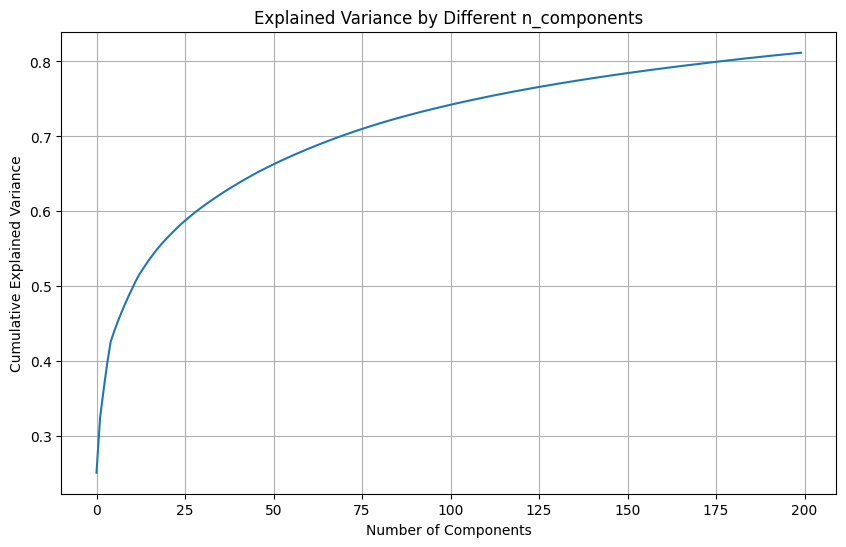

In [27]:
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import explained_variance_score
import matplotlib.pyplot as plt

svd = TruncatedSVD(n_components=200)
reduced_matrix = svd.fit_transform(song_interaction_matrix)

# Plotting explained variance
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(svd.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Different n_components')
plt.grid(True)
plt.show()


In [ ]:
import pickle as
# Set the path to the dataset folder
dataset_path = '/content/drive/My Drive/DATASET'

# Save the mappings and reduced matrix
with open(f'{dataset_path}/song_name_to_index.pkl', 'wb') as f:
    pickle.dump(song_name_to_index, f)
np.save(f'{dataset_path}/reduced_matrix.npy', reduced_matrix)

# Save the interaction matrix if necessary
save_npz(f'{dataset_path}/song_interaction_matrix.npz', song_interaction_matrix)
